# Shortterm Forecast

This notebook documents the workflow to use 3DCORE for shortterm forecast.

In [1]:
from pathlib import Path
import datetime
import pandas as pd

import re
import urllib

import pickle

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append(str(Path.cwd().parent)) 

from src.data.data_cache import get_data_cache
from src.methods.utils import get_modelkwargs_ranges
from src.methods.fitting import standard_fit, load_fit_parameters, load_ensemble
from src.methods.plotting import plot_insitu_results, plot_3d_results, scatterparams

cache_path = Path.cwd().parent / "cache"


###################################
# settings for plots
###################################

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('paper')

insitu_colors = ['#c20078','#f97306', '#069af3']

SMALLEST_SIZE = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Kernels path loaded: /Volumes/SSDPortable/data/kernels
File names loaded
Data path loaded: /Volumes/SSDPortable/data
Data path loaded: /Volumes/SSDPortable/data


#### Data Preprocessing

We check the [CME Scoreboard](https://kauai.ccmc.gsfc.nasa.gov/CMEscoreboard/) for any suitable CME.

In [2]:
event_id_donki = '2021-08-23T06:36:00-CME-001'
event_time_donki = datetime.datetime.strptime(event_id_donki.split('-CME-')[0].split('T')[0], '%Y-%m-%d')

# start one day before and one day after
start_date = (event_time_donki - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
end_date = (event_time_donki + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+start_date+'&endDate='+end_date+'&mostAccurateOnly=true'
try: urllib.request.urlretrieve(url_donki,cache_path / Path('DONKI.json'))
except urllib.error.URLError as e:
    print('DONKI not loaded')

donkicat = pd.read_json(cache_path / 'DONKI.json')
print(f'# CMEs between {start_date} and {end_date}: ', len(donkicat))


# choose correct CME from DONKI

filtered_donki = donkicat[donkicat['associatedCMEID'].str.contains(event_id_donki)] # we extract the event with the correct ID
print('# CMEs filtered: ', len(filtered_donki))

# choose correct one!

catalogevent = filtered_donki.iloc[0]

for col in donkicat.columns:
    print(str(col) +': '+ str(catalogevent[col]))

dateFormat = "%Y-%m-%dT%H:%MZ"
cataloglaunchtime = datetime.datetime.strptime(catalogevent['time21_5'], dateFormat)

# CMEs between 2021-08-22 and 2021-08-24:  6
# CMEs filtered:  1
time21_5: 2021-08-23T14:36Z
latitude: 11
longitude: -1
halfAngle: 35
speed: 393
type: S
isMostAccurate: True
associatedCMEID: 2021-08-23T06:36:00-CME-001
associatedCMEstartTime: 2021-08-23T06:36Z
note: 
associatedCMELink: https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/17559/-1
catalog: M2M_CATALOG
featureCode: null
dataLevel: 0
measurementTechnique: SWPC_CAT
imageType: running difference
tilt: nan
minorHalfWidth: nan
speedMeasuredAtHeight: nan
submissionTime: 2021-08-23T18:39Z
versionId: 1
link: https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CMEAnalysis/17560/-1


#### Prepare Data

In [3]:
idd = 'ICME_NOAA_ARCHIVE_CUSTOM_20210827_01' # this is the ID of the event we want to analyze

t_s = datetime.datetime(2021, 8, 27, 12, 16, tzinfo=None) # will be set to data_cache.mo_begin if None
t_e = datetime.datetime(2021, 8, 28, 14, 30, tzinfo=None)

########## IMPORTANT ##########
# reduce delta_t_days to reduce computation time during ensemble generation (but make sure its large enough to calculate the mean solar wind speed before the event)
###############################

data_cache = get_data_cache(
    idd, 
    mean_hours=24, # mean_hours is the number of hours before the event to calculate the mean solar wind speed
    delta_t_days = 1, # number of days before and after the event to process data for
    assumed_duration_hours=36, # assumed duration of the ICME in hours, used to define start and end time of the event if mo_begin and mo_end are not given
    mo_begin=t_s, 
    mo_end=t_e
    ) 

output_path = Path.cwd().parent / "output"
output_folder = output_path / data_cache.idd

Loading data from cache for ICME_NOAA_ARCHIVE_CUSTOM_20210827_01


/var/folders/xy/v4wq5m110gn32553dwbc7d7c0000gn/T/ipykernel_52225/2811661369.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


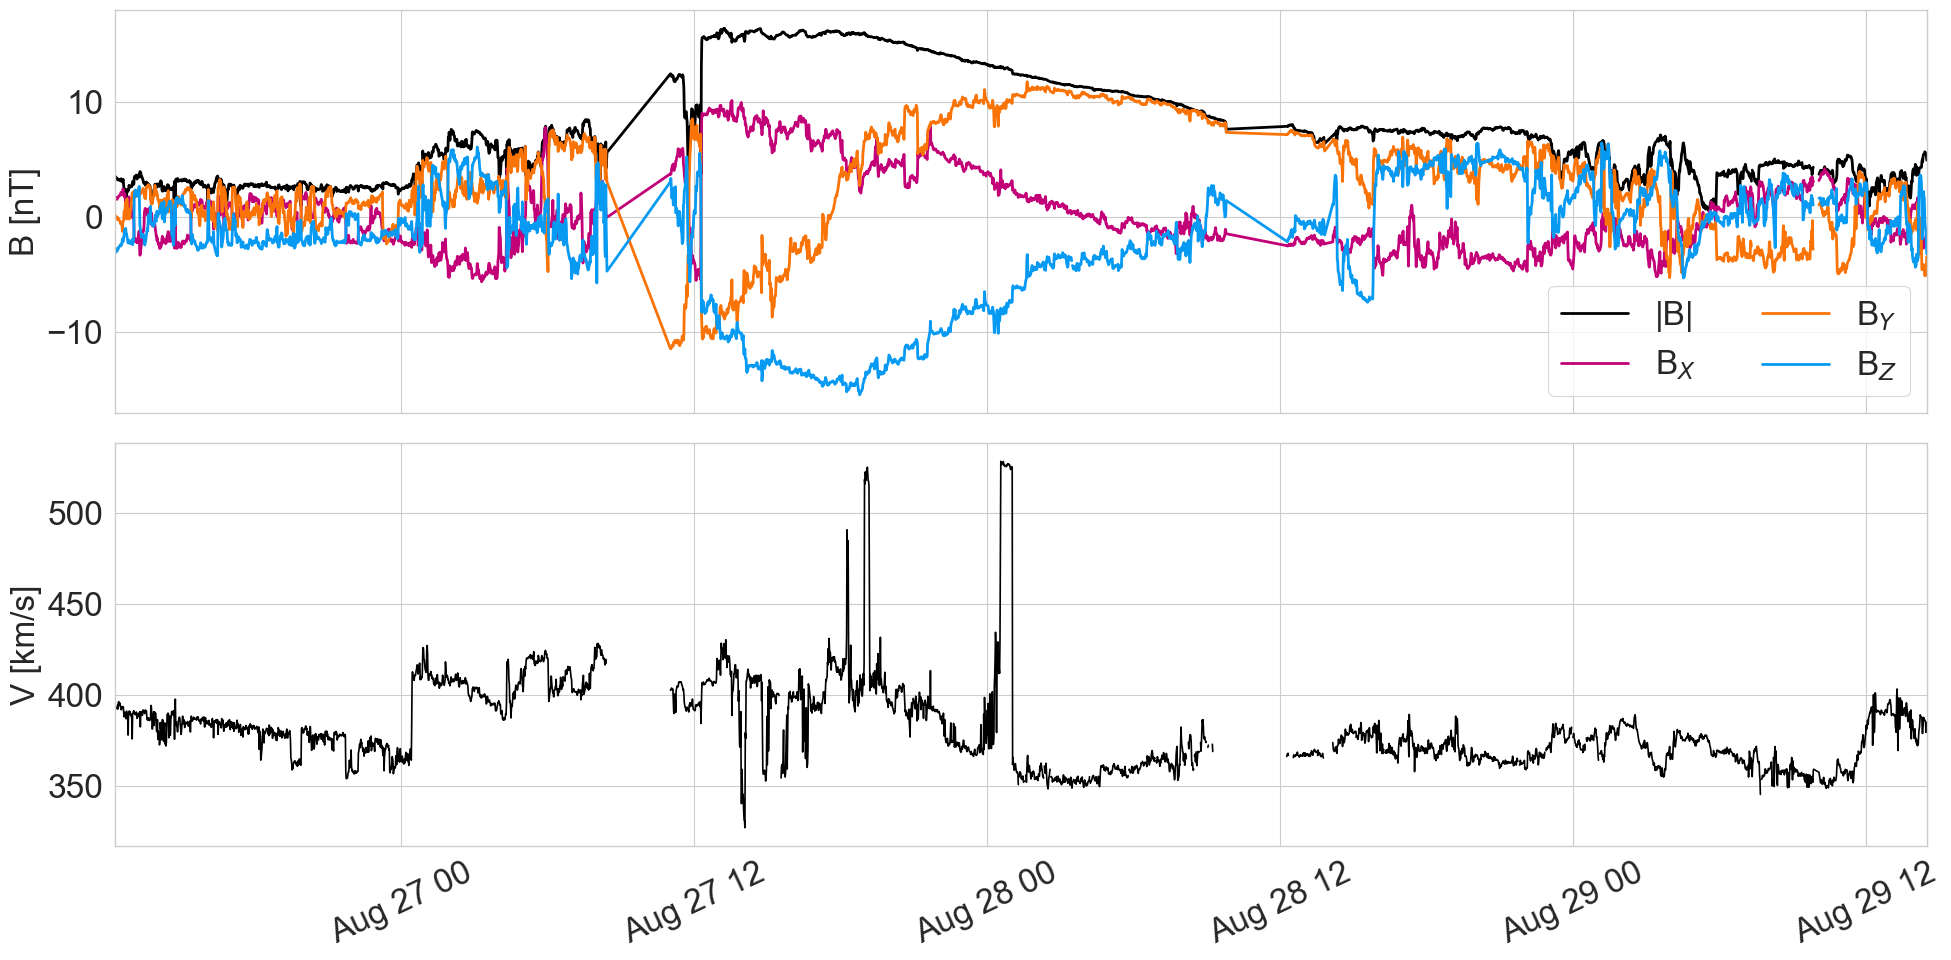

In [4]:
save_quick_insitu_plot = True

fig, axes = data_cache.quick_insitu_plot(
    reference_frame="GSM", 
    delta_time_hours=24, # time before and after the event to plot
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2
)

if save_quick_insitu_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache.idd}_insitu_quicklook.png", dpi=200)

fig.show()

/var/folders/xy/v4wq5m110gn32553dwbc7d7c0000gn/T/ipykernel_52225/3822469402.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


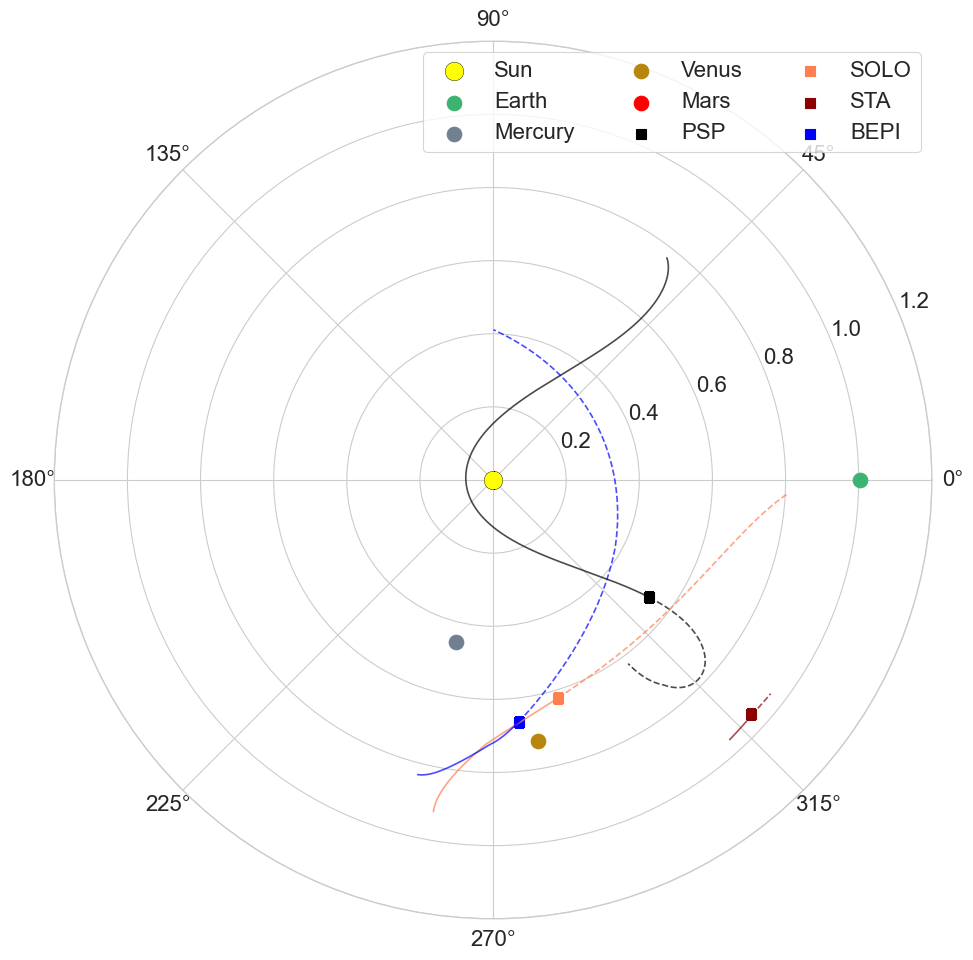

In [5]:
save_quick_positions_plot = True

fig, ax = data_cache.quick_positions_plot(
    fontsize=SMALLEST_SIZE,
    figsize=(20,10)
)

if save_quick_positions_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache.idd}_positions_quicklook.png", dpi=200)

fig.show()

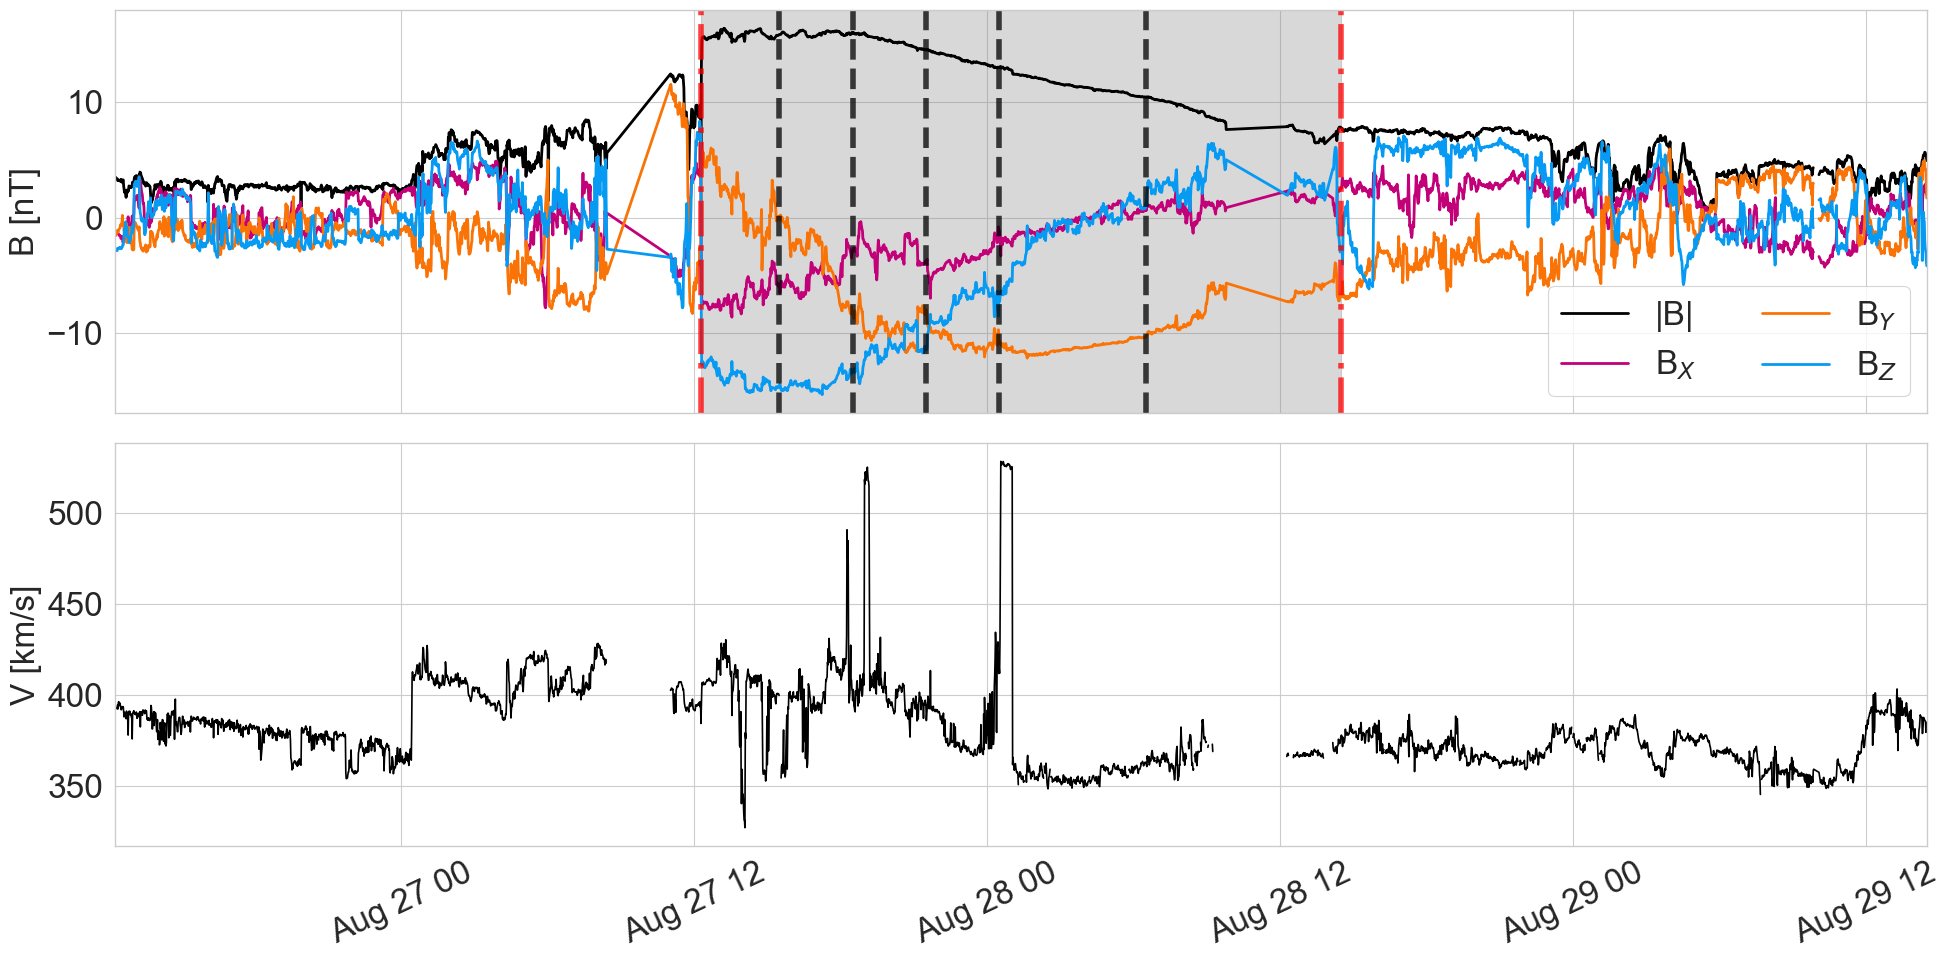

In [6]:
t_launch = cataloglaunchtime.replace(tzinfo=None) # choose launch time

t_fit =[
    datetime.datetime(2021, 8, 27, 15, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2021, 8, 27, 18, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2021, 8, 27, 21, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2021, 8, 28, 0, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2021, 8, 28, 6, 30, tzinfo=datetime.timezone.utc),
]

save_quick_fitting_points_plot = True

fig, axes = data_cache.check_fitting_points(
    t_s, 
    t_e, 
    t_fit, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_fitpts=4,
    delta_time_hours=24
)

if save_quick_fitting_points_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache.idd}_insitu_fittingpoints.png", dpi=200)

In [7]:
longitude_delta = 40
latitude_delta = 30

speed_delta = 100

bg_v_delta = 100
bg_v = data_cache.v_mean_before_event


modelstatevar_ranges = [
    int(2**18) # ensemblesize
    ] + [
        [catalogevent['longitude'] - longitude_delta,catalogevent['longitude']+longitude_delta], # Longitude (HEEQ)
        [catalogevent['latitude'] - latitude_delta,catalogevent['latitude'] +latitude_delta], # Latitude (HEEQ)
        [0.,360.], # Inclination
        [0.05,0.35], # Diameter 1 AU 
        [1.,3.5], # Aspect Ratio  
        [21.5,21.5], # Launch Radius
        [catalogevent['speed'] - speed_delta, catalogevent['speed'] + speed_delta], # Launch Velocity
        [1.,2.0], # Expansion Rate
        [0.20,3.00], # Background Drag
        [bg_v - bg_v_delta, bg_v + bg_v_delta], # Background Velocity
        [-250.,250.], # T_Factor
        [1.,2.], # Magnetic Decay Rate
        [5.,65.], # Magnetic Field Strength 1 AU
    ]

modelkwargs = get_modelkwargs_ranges(modelstatevar_ranges)

multiprocessing = True

njobs = 4

itermin = 12
itermax = 15

n_particles = 512

In [11]:
rerun_fitting = False

fit_number = "last" # "last" or integer

if rerun_fitting:
    extra_args = standard_fit(
        data_cache = data_cache,
        t_launch=t_launch,
        t_s=t_s,
        t_e=t_e,
        t_fit=t_fit,
        model_kwargs=modelkwargs,
        njobs=njobs,
        multiprocessing=multiprocessing,
        itermin=itermin,
        itermax=itermax,
        n_particles=n_particles,
    )

if fit_number == "last":
    fit_files = [
        f for f in output_folder.glob("*.pickle")
        if re.match(r"^\d{2}\.pickle$", f.name)
    ]
    fit_files.sort()

    if fit_files == []:
        print(f"No fitting results found, set rerun_fitting to True")
    else:
        fit_file = fit_files[-1]
else:
    fit_file = output_folder / f"{fit_number:02d}.pickle"

try:
    with open(fit_file, "rb") as fh:
        extra_args = pickle.load(fh)

    print("Loaded fit from file: ", fit_file)
except:
    print(f"Error loading fit results")


Loaded fit from file:  /Users/hannahruedisser/3DCORE-ASWO/output/ICME_NOAA_ARCHIVE_CUSTOM_20210827_01/05.pickle


In [13]:
ensemble_data = load_ensemble(output_folder= output_folder, fit_file=fit_file, data_cache=data_cache)

Loaded ensemble from /Users/hannahruedisser/3DCORE-ASWO/output/ICME_NOAA_ARCHIVE_CUSTOM_20210827_01/ensemble_05.pickle


In [14]:
results_df, stats_df = load_fit_parameters(fit_file=fit_file, t0=t_launch)

/Users/hannahruedisser/3DCORE-ASWO/src/methods/fitting.py:429: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)


In [15]:
results_df.head()

,Index,RMSE Ɛ,Longitude,Latitude,Inclination,Diameter 1 AU,Aspect Ratio,Launch Radius,Launch Velocity,T_Factor,Expansion Rate,Magnetic Decay Rate,Magnetic Field Strength 1 AU,Background Drag,Background Velocity,Number of Twists,Launch Time
0,0,0.46,22.88,17.16,24.53,0.12,2.76,21.5,428.87,-48.46,1.72,1.50,11.62,2.62,430.74,-3.89,2021-08-23 14:36
1,1,0.46,15.26,24.12,43.48,0.14,1.72,21.5,412.55,-32.36,1.89,1.99,16.60,0.99,458.65,-3.72,2021-08-23 14:36
2,2,0.38,21.30,22.49,42.08,0.14,1.87,21.5,341.91,-39.85,1.59,1.60,13.61,1.87,472.80,-4.32,2021-08-23 14:36
3,3,0.44,16.22,22.43,48.41,0.13,2.33,21.5,431.09,-25.36,1.71,1.66,15.42,1.76,432.98,-2.33,2021-08-23 14:36
4,4,0.43,-4.11,8.80,60.18,0.14,3.47,21.5,401.17,-39.26,1.34,1.47,15.24,1.68,384.20,-2.60,2021-08-23 14:36


In [16]:
stats_df.head()

,Index,RMSE Ɛ,Longitude,Latitude,Inclination,Diameter 1 AU,Aspect Ratio,Launch Radius,Launch Velocity,T_Factor,Expansion Rate,Magnetic Decay Rate,Magnetic Field Strength 1 AU,Background Drag,Background Velocity,Number of Twists,Launch Time
0,Mean,0.42,10.86,16.01,39.66,0.16,2.53,21.5,401.77,-39.38,1.48,1.53,14.83,1.66,425.73,-3.55,2021-08-23 14:36
1,Standard Deviation,0.03,11.25,5.94,8.99,0.02,0.61,0.0,49.81,13.67,0.28,0.26,2.15,0.72,34.99,1.56,2021-08-23 14:36
2,Median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-23 14:36
3,Minimum,0.30,-27.69,-7.38,12.68,0.10,1.02,21.5,294.10,-91.37,1.00,1.01,9.82,0.20,285.47,-9.99,2021-08-23 14:36
4,Maximum,0.46,32.81,31.61,62.12,0.25,3.50,21.5,492.80,-10.67,1.99,2.00,20.96,3.00,484.40,-0.79,2021-08-23 14:36


In [17]:
max_col_width = max(len(str(col)) for col in stats_df.columns[2:-1])

for col in stats_df.columns[1:-1]:
    print('{:<{}}{:>20} +/- {:>20}'.format(str(col) + ':', max_col_width + 1, str(stats_df[col][0]), str(stats_df[col][1])))

RMSE Ɛ:                                      0.42 +/-                 0.03
Longitude:                                  10.86 +/-                11.25
Latitude:                                   16.01 +/-                 5.94
Inclination:                                39.66 +/-                 8.99
Diameter 1 AU:                               0.16 +/-                 0.02
Aspect Ratio:                                2.53 +/-                 0.61
Launch Radius:                               21.5 +/-                  0.0
Launch Velocity:                           401.77 +/-                49.81
T_Factor:                                  -39.38 +/-                13.67
Expansion Rate:                              1.48 +/-                 0.28
Magnetic Decay Rate:                         1.53 +/-                 0.26
Magnetic Field Strength 1 AU:               14.83 +/-                 2.15
Background Drag:                             1.66 +/-                 0.72
Background Velocity:     

In [18]:
row = results_df.iloc[results_df['RMSE Ɛ'].idxmin()] # extract parameters from minimum eps row

In [19]:
stats_df

,Index,RMSE Ɛ,Longitude,Latitude,Inclination,Diameter 1 AU,Aspect Ratio,Launch Radius,Launch Velocity,T_Factor,Expansion Rate,Magnetic Decay Rate,Magnetic Field Strength 1 AU,Background Drag,Background Velocity,Number of Twists,Launch Time
0,Mean,0.42,10.86,16.01,39.66,0.16,2.53,21.5,401.77,-39.38,1.48,1.53,14.83,1.66,425.73,-3.55,2021-08-23 14:36
1,Standard Deviation,0.03,11.25,5.94,8.99,0.02,0.61,0.0,49.81,13.67,0.28,0.26,2.15,0.72,34.99,1.56,2021-08-23 14:36
2,Median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-23 14:36
3,Minimum,0.30,-27.69,-7.38,12.68,0.10,1.02,21.5,294.10,-91.37,1.00,1.01,9.82,0.20,285.47,-9.99,2021-08-23 14:36
4,Maximum,0.46,32.81,31.61,62.12,0.25,3.50,21.5,492.80,-10.67,1.99,2.00,20.96,3.00,484.40,-0.79,2021-08-23 14:36
5,Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-23 14:36
6,Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-23 14:36
7,Skewness,-1.13,-0.75,-0.70,0.04,0.69,-0.40,0.0,-0.11,-0.60,0.02,-0.15,0.34,-0.11,-0.51,-1.11,2021-08-23 14:36
8,Kurtosis,1.24,0.36,1.10,-0.31,1.11,-0.66,0.0,-0.86,0.54,-1.08,-0.98,-0.22,-0.97,-0.12,1.62,2021-08-23 14:36


In [20]:
# write results to file

result_file_path = output_folder / "results.txt"

with open(result_file_path, "w") as file:
    for col in stats_df[2:-1]:
        file.write('{:<{}}{:>20} +/- {:>20}'.format(str(col) + ':', max_col_width + 1, str(stats_df[col][0]), str(stats_df[col][1])))
        file.write('\n')


        
    file.write('\n')
    for col in stats_df.columns[1:-1]:
        index = stats_df.columns.get_loc(str(col))
        file.write('{:<{}}{:>20}'.format(str(col) + ':', max_col_width + 1, str(row[index])))
        file.write('\n')

    file.write('\n')
    file.write('Parameter ranges')
    file.write('\n')
    file.write(str(modelstatevar_ranges))
    file.write('\n')
    file.write('Launch time')
    file.write('\n')
    file.write(str(t_launch))
    file.write('\n')
    file.write('Start time for reconstruction')
    file.write('\n')
    file.write(str(t_s))
    file.write('\n')
    file.write('End time for reconstruction')
    file.write('\n')
    file.write(str(t_e))
    file.write('\n')
    file.write('Fitting points for reconstruction')
    file.write('\n')
    file.write(str(t_fit))
    file.write('\n')


file.close()   

/var/folders/xy/v4wq5m110gn32553dwbc7d7c0000gn/T/ipykernel_52225/3912563950.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file.write('{:<{}}{:>20}'.format(str(col) + ':', max_col_width + 1, str(row[index])))


/Users/hannahruedisser/miniforge3/envs/aswocore-env/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


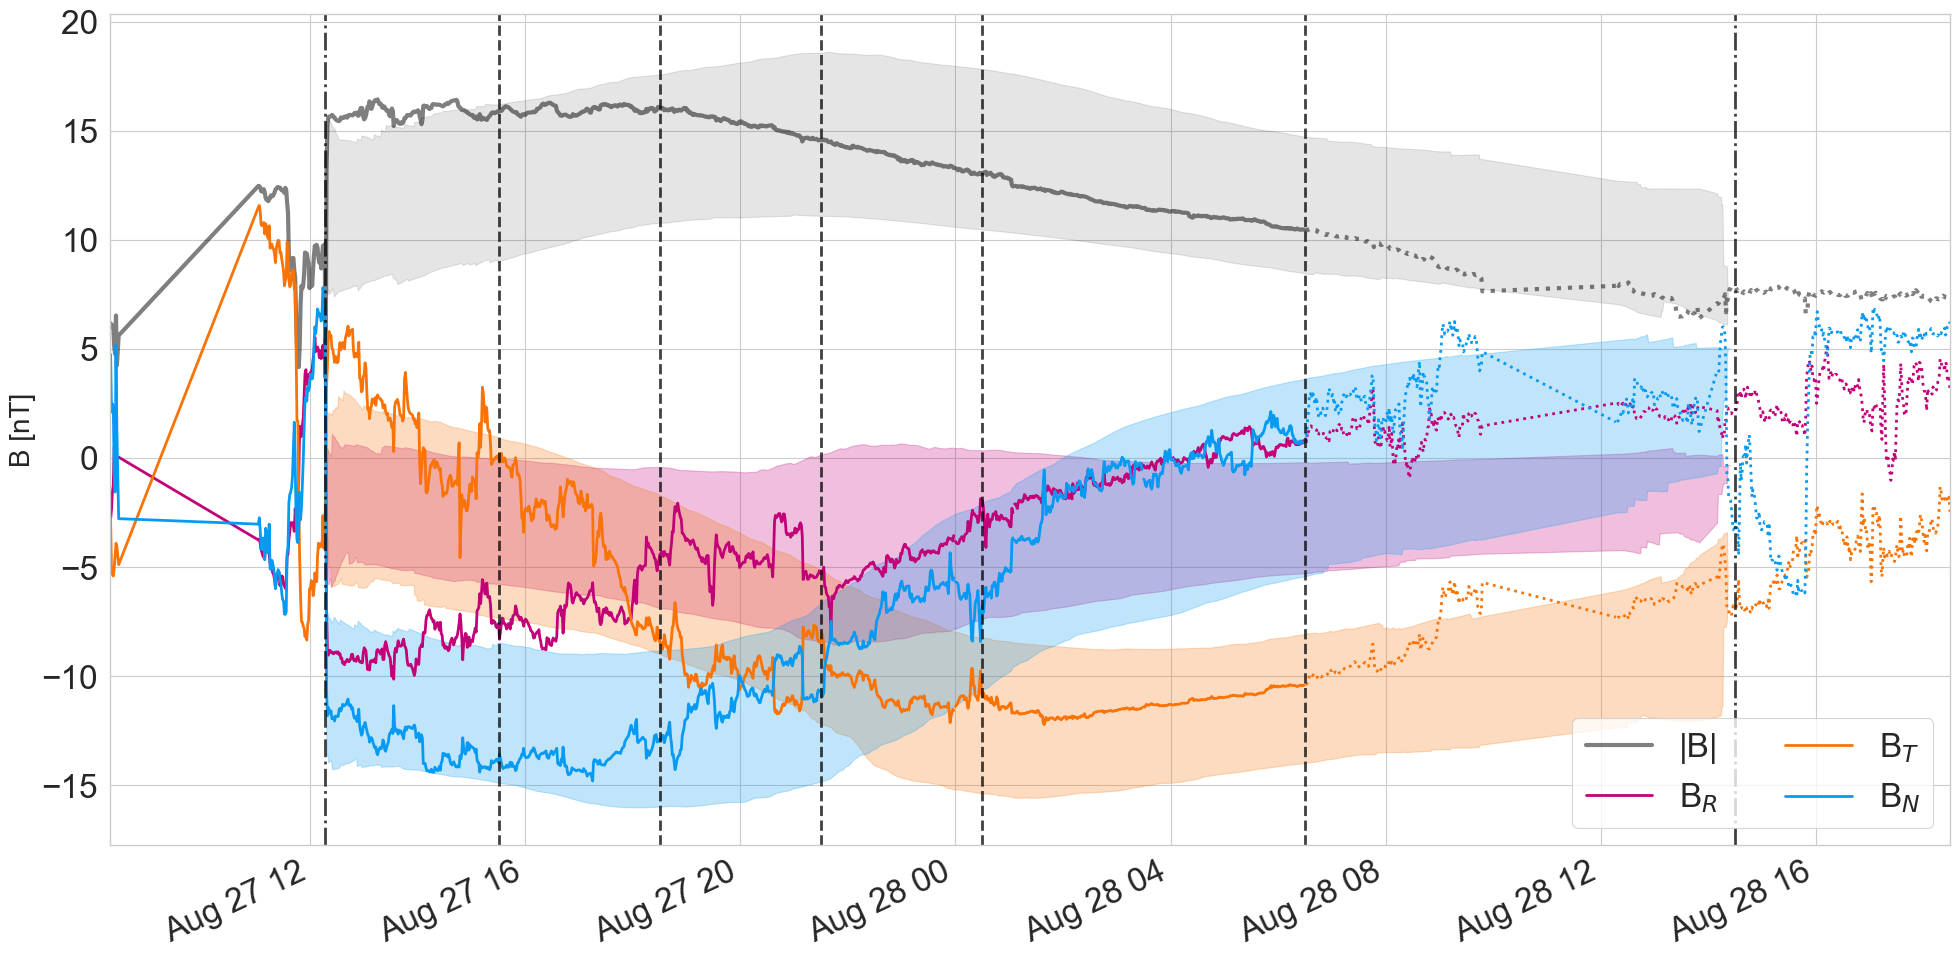

In [21]:
save_quick_results_plot = True

if t_s is not None and t_e is not None:
    insitu_start = t_s - datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
    insitu_end = t_e + datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
else:
    insitu_start = None
    insitu_end = None


fig, ax = plot_insitu_results(
    data_cache=data_cache,
    reference_frame="RTN",
    delta_time_hours=2,
    insitu_start=insitu_start,
    insitu_end=insitu_end,
    t_s = t_s, # set to None if not to be plotted
    t_e = t_e, # set to None if not to be plotted
    t_fit = t_fit, # set to None if not to be plotted
    colors = insitu_colors,
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_best=3,
    lw_mean=3,
    lw_fitpts=2,
    ensemble_data=ensemble_data,
    prediction=True
)

if save_quick_results_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache.idd}_insitu_fitresults.png", dpi=200)

In [22]:
# Set new elements for data_cache so they can be used later on

data_cache.row = row

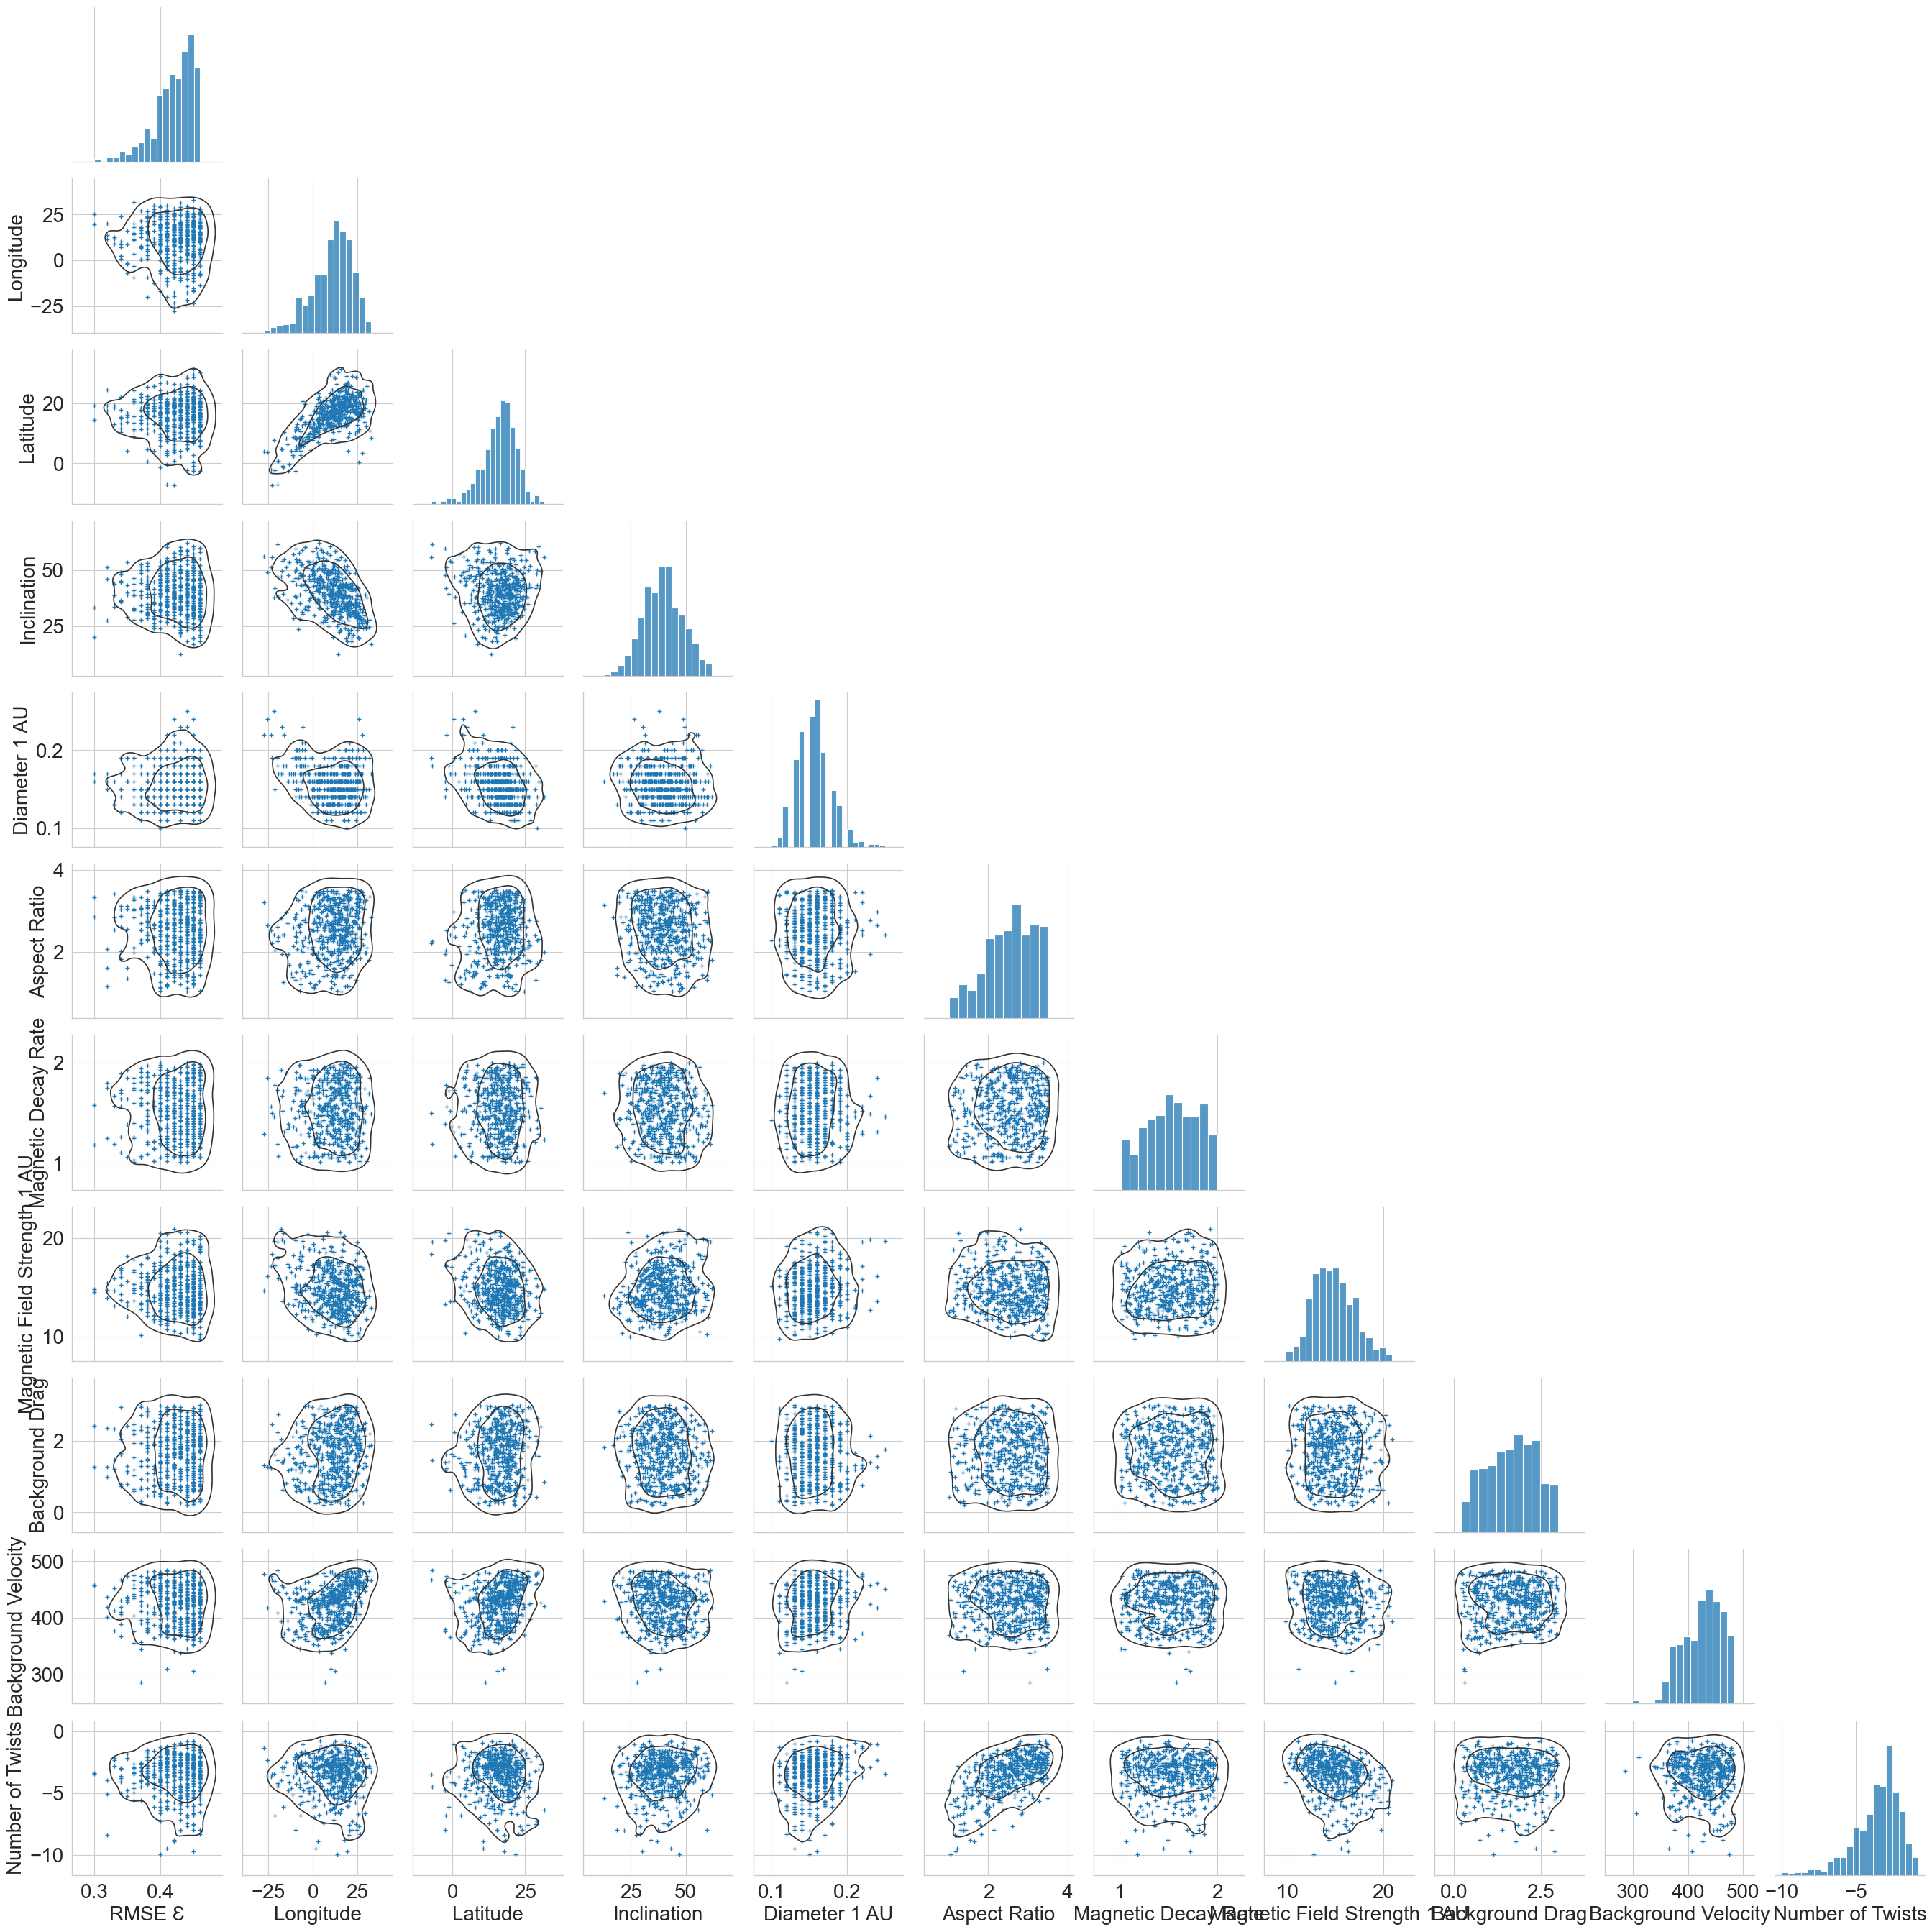

In [23]:
save_scatterplot = True

fig = scatterparams(results_df)

if save_scatterplot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache.idd}_parameter_scatterplot.png", dpi=200)